
From George Hotz:
Machine Learning Engineers:
 - Download a paper
 - Implement it
 - Keep doing this until you have skills

Building infrastructure around the model and data processing steps is important as well

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch: https://arxiv.org/abs/2010.11929 


torchvison.models.vit_b_16

In [107]:
import torch
from torch import nn

import torchvision
from torchvision import transforms

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt


from pathlib import Path

import random

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.7.1
torchvision version: 0.22.1


In [108]:
from utils import data_setup, engine
from utils.helper_functions import download_data, plot_loss_curves

In [109]:
# device agnostic
device = "mps" if torch.mps.is_available() else "cpu"
device

'mps'

1. Data preparation

In [110]:
# get data
image_path=Path("data/pizza_steak_sushi")
train_dir = image_path / "train"
test_dir=image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [111]:
# create datasets and turn into dataloader
# first create a transforms

IMG_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
]
)
manual_transforms


Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [112]:
BATCH_SIZE = 32 # Friends don't let friends use mini-batches larger than 32
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [113]:
# just check a single image to check -- always
# get a batch of images first
image_batch, label_batch=next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]
image.shape, label

/Users/mikeqin/code/ml_learning/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([3, 224, 224]), tensor(2))

2. Data understanding and verification

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

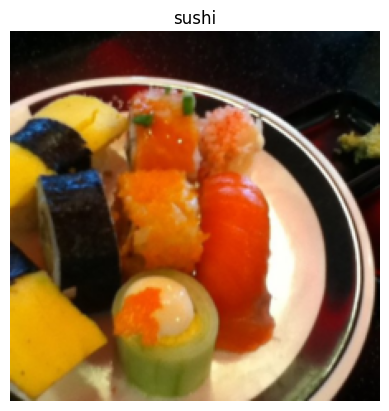

In [114]:
# plot it
# matplotlib like to have the color channel last so we have to permute the image
plt.imshow(image.permute(1,2,0)) # (color_channels, h, w)->(h, w, color_channels)
plt.title(class_names[label])
plt.axis(False)

### Figure 1

<img src="./vit_paper_image/vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper"/>

* Embedding = learnable representation (start with random numbers and improve over time) 



***

Create image patches and turn them into patch embeddings - Equation 1 here:

<img src="./vit_paper_image/vit-paper-four-equations.png" width=600 style="float: left;" alt="four equations from vision transformer paper"/>


In [115]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16 

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [116]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


In [117]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16

Number of patches per row: 14.0  
Number of patches per column: 14.0  
Total patches: 196.0  
Patch size: 16 pixels x 16 pixels


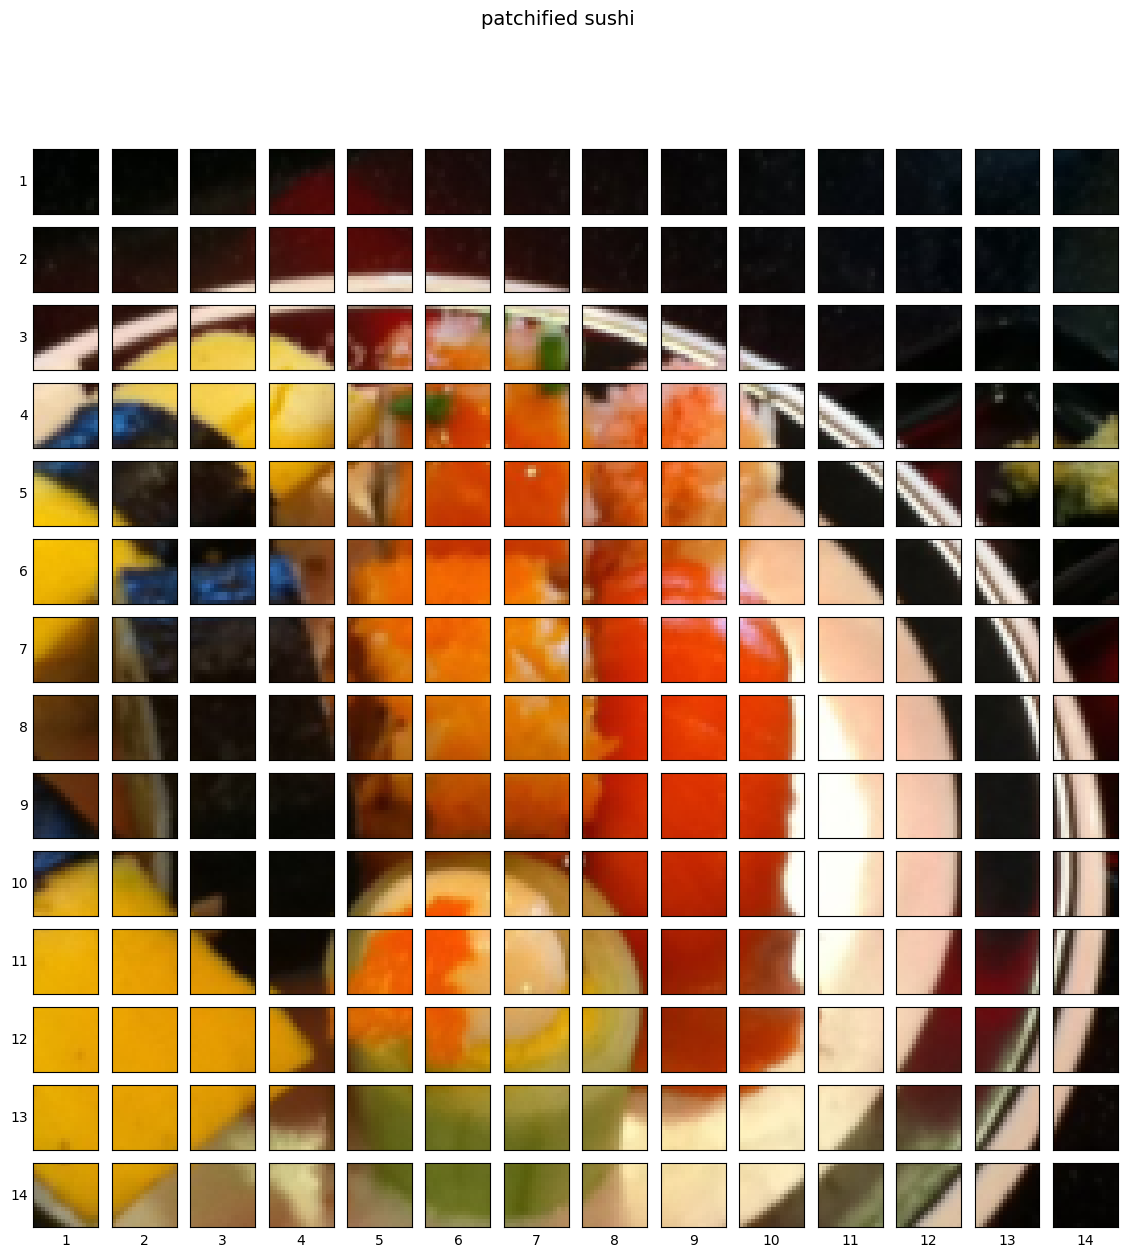

In [118]:
# Setup code to plot whole image as patches
img_size = 224
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
  \nNumber of patches per column: {num_patches}\
  \nTotal patches: {num_patches*num_patches}\
  \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image on the different axes 
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                    patch_width:patch_width+patch_size, # iterate through width
                                    :]) # get all color channels
    # Set up label information for each subplot (patch)
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f"patchified {class_names[label]}", fontsize=14)
plt.show()

In [119]:
# take a long time to create these patches. Conv2d is a good replacement

# Create a conv2d lyaer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # for color images
                   out_channels=768, # D size from Table 1 for ViT-Base, that is, 3*16*16=768
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

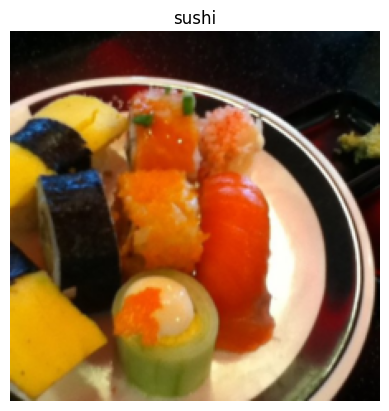

In [120]:
#view a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [121]:
#pass the image through the converlutional layer
# learnable...
image_out_of_conv = conv2d(image.unsqueeze(0))
image_out_of_conv.shape, image_out_of_conv.requires_grad

(torch.Size([1, 768, 14, 14]), True)

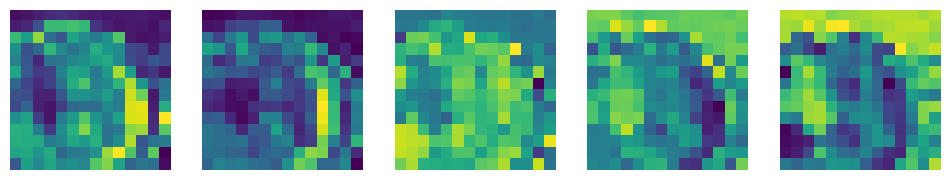

In [122]:
# plot random convolutional feature maps (embeddings)
random_indexs = random.sample(range(0, 768), k =5)

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,12))
for i, idx in enumerate(random_indexs):
    image_conv_feature_map = image_out_of_conv[:, idx, :]
    ax[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    ax[i].set(xticklabels=[]) #set_xticks([])
    ax[i].set(yticklabels=[])
    ax[i].axis(False)

In [123]:
#  the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension
#  we wanted to flat the dimentions of 14 and 14
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
image_of_conv_flattend = flatten_layer(image_out_of_conv)
image_of_conv_flattend.shape

torch.Size([1, 768, 196])

want: (batch_size, num_of_patches, embedding_dim)

In [124]:
image_of_conv_flattend_permuted = image_of_conv_flattend.permute(0,2,1)
image_of_conv_flattend_permuted.shape


torch.Size([1, 196, 768])

In [125]:
# visualize the single flattened feature map
single_flattened_feature_map = image_of_conv_flattend_permuted[:,:,0]
single_flattened_feature_map


tensor([[-0.0075, -0.0089,  0.0091,  0.0140,  0.0195,  0.0069,  0.0009, -0.0039,
         -0.0063,  0.0016, -0.0246, -0.0261, -0.0094, -0.0102, -0.0088,  0.0215,
         -0.0038,  0.0979,  0.0527,  0.0420,  0.0218,  0.0087, -0.0037, -0.0163,
         -0.0188, -0.0128, -0.0038, -0.0010,  0.1736, -0.0308,  0.3064,  0.1153,
          0.1747,  0.1210,  0.0791, -0.2001,  0.1159, -0.1334, -0.0037, -0.0206,
         -0.0083, -0.0089, -0.1736, -0.0692,  0.2298,  0.1251,  0.0562,  0.1806,
          0.1705,  0.1363,  0.2509,  0.1005,  0.0521, -0.0073, -0.0436,  0.0884,
          0.1928,  0.0599, -0.0432,  0.0771, -0.0122,  0.1427,  0.1453,  0.1439,
          0.1742,  0.1876, -0.0771, -0.0612,  0.0552,  0.1276,  0.2221, -0.0435,
         -0.0608,  0.0742,  0.1387,  0.1948,  0.1500,  0.1727,  0.2575,  0.0802,
         -0.0929, -0.1556, -0.1341, -0.0502,  0.0522, -0.0815,  0.0043, -0.0196,
          0.1905,  0.1731,  0.2165,  0.1798,  0.2976,  0.2111,  0.0957, -0.0817,
          0.1910,  0.0347,  

(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

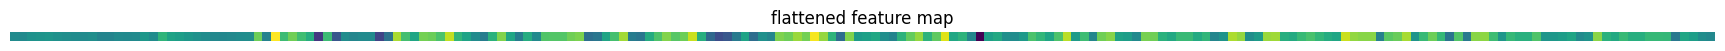

In [126]:
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title("flattened feature map")
plt.axis(False)

3. Enough experiment and verifications. Create embeddings

In [127]:
# create patch embedding

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3,
                 embedding_dimention: int=768, # from table 1 for ViT-Base
                 patch_size:int=16):
        super().__init__()
        # self.patcher = nn.Conv2d(in_channels=in_channels,
        #               out_channels=embedding_dimention,
        #               kernel_size=patch_size,
        #               stride=patch_size,
        #               padding=0)
        # self.flatten = nn.Flatten(start_dim=2,
        #                           end_dim=3)
        
        # a sequence
        self.patch_and_flatten = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=embedding_dimention,
                      kernel_size=patch_size,
                      stride=patch_size,
                      padding=0),
            nn.Flatten(start_dim=2,
                      end_dim=3)
        )


    def forward(self, x):
        # check the image resolution is compatible 
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"image size {image_resolution} must be divisible by patch_size {patch_size}"

        #patched = self.patcher(x)
        #flattened = self.flatten(patched)
        flattened = self.patch_and_flatten(x)

        return flattened.permute(0,2,1)


In [128]:
# quick verification of PatchEmbedding
torch.manual_seed(42)
torch.mps.manual_seed(42)

print(f"image size: {image.unsqueeze(0).shape}")
patchify = PatchEmbedding()
patch_embedding_image=patchify(image.unsqueeze(0)) # add an extra batch dimension

patch_embedding_image.shape

image size: torch.Size([1, 3, 224, 224])


torch.Size([1, 196, 768])

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>

In [129]:
# adding class token embedding X_class
# class tokens are learnable as well
# prepend the tokens to the start of the patch embedding

# 1. prepare the size
batch_size = patch_embedding_image.shape[0]
embedding_dimension = patch_embedding_image.shape[-1]
batch_size, embedding_dimension

# 2. create class token with random values
class_token = nn.Parameter(torch.randn(batch_size, 1, # <-- can use torch.ones(...) so that you can tell the first patch after prepending is this patch
                                      embedding_dimension,
                                      requires_grad=True)) # default but sepcify for clear
class_token.shape

# 3. prepend to patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token,
                                                       patch_embedding_image),
                                                       dim=1)

print(patch_embedded_image_with_class_embedding)
print(patch_embedded_image_with_class_embedding.shape) #197 patches 196 + 1

tensor([[[ 0.5436, -0.4700, -1.2133,  ..., -0.4571,  0.4486,  0.1217],
         [-0.0401, -0.0100, -0.0392,  ...,  0.0325, -0.0079,  0.0180],
         [-0.0595, -0.0067, -0.0510,  ...,  0.0248, -0.0055,  0.0226],
         ...,
         [-0.6314,  0.1208, -0.2373,  ...,  0.4329, -0.2400,  0.1630],
         [-0.4423, -0.0585, -0.0581,  ...,  0.1002, -0.0822,  0.4985],
         [-0.0403, -0.0031, -0.0240,  ...,  0.0272, -0.0169,  0.0047]]],
       grad_fn=<CatBackward0>)
torch.Size([1, 197, 768])


<img src="./vit_paper_image/vit-paper-four-equations.png" width=600 style="float: left;" alt="four equations from vision transformer paper"/>

In [130]:
# create position embedding E_pos 
# it will be the same shape as patch_embedded_image_with_class_embedding
position_embedding = nn.Parameter(torch.randn(batch_size,
                                             number_of_patches + 1,
                                             embedding_dimension),
                                  requires_grad=True)

position_embedding, position_embedding.shape


(Parameter containing:
 tensor([[[-1.0264, -2.4631,  0.1703,  ...,  0.1468,  1.3768,  0.5802],
          [-0.6950,  0.7188, -1.1410,  ..., -0.3153, -2.2221, -0.6922],
          [-1.5855, -0.3176, -1.4012,  ...,  1.7983,  0.5078,  0.0315],
          ...,
          [ 1.2855,  0.8303,  0.1497,  ..., -0.4751,  1.2664,  0.6758],
          [-0.0406, -0.5170, -0.3489,  ..., -0.4922,  0.3503,  1.3471],
          [-0.2454, -0.0047,  1.4984,  ..., -0.4075,  1.5785, -0.3281]]],
        requires_grad=True),
 torch.Size([1, 197, 768]))

In [131]:
# add the postion (see Formula 1)
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding, patch_and_position_embedding.shape

(tensor([[[-0.4828, -2.9331, -1.0430,  ..., -0.3104,  1.8254,  0.7019],
          [-0.7351,  0.7089, -1.1802,  ..., -0.2828, -2.2301, -0.6742],
          [-1.6450, -0.3244, -1.4522,  ...,  1.8231,  0.5022,  0.0541],
          ...,
          [ 0.6541,  0.9511, -0.0876,  ..., -0.0423,  1.0264,  0.8388],
          [-0.4829, -0.5755, -0.4069,  ..., -0.3920,  0.2681,  1.8456],
          [-0.2857, -0.0078,  1.4744,  ..., -0.3803,  1.5616, -0.3234]]],
        grad_fn=<AddBackward0>),
 torch.Size([1, 197, 768]))

In [132]:
# Put all equation 1 together here:
torch.manual_seed(42)
torch.mps.manual_seed(42)

patch_size = 16
height, width = image.shape[1], image.shape[2] # (channels, height, weight)

# ad a batch dimention
x = image.unsqueeze(0)
print(f"image shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3, patch_size=patch_size, embedding_dimention=768)
patch_embedding = patch_embedding_layer(x)
print(f"patch embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding_image.shape[0]
embedding_dimension = patch_embedding_image.shape[-1]

class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True)

print(f"class token embedding shape {class_token.shape}")

#prepend class token
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"patch_embedding_class_token shape {patch_embedding_class_token.shape}")

number_patches = int(height*width/patch_size**2)
position_embedding = nn.Parameter(torch.randn(1, number_of_patches + 1, embedding_dimension),
                                  requires_grad=True)
print(f"patch_embedding shape {position_embedding.shape}")

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"patch_and_position_embedding shape {patch_and_position_embedding.shape}")

image shape: torch.Size([1, 3, 224, 224])
patch embedding shape: torch.Size([1, 196, 768])
class token embedding shape torch.Size([1, 1, 768])
patch_embedding_class_token shape torch.Size([1, 197, 768])
patch_embedding shape torch.Size([1, 197, 768])
patch_and_position_embedding shape torch.Size([1, 197, 768])


***

Next work on Equation 2 MSA Block

<img src="./vit_paper_image/vit-paper-four-equations.png" width=600 style="float: left;" alt="four equations from vision transformer paper"/>

MSA - Multihead Self-Attention: MSA Block

Self-attention: which part of a sequence should pay the most attention to itself?
* in our case, we have a series of embedded image patches, which patch signifficantly relate to another patch?

* LayerNorm: layer normalization (LayerNorm) is a technique to normalize the distribution of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
(make everything have the same mean and same standard deviation.)

<img src="./vit_paper_image/vit-paper-table-1.png" width=600 alt="Table 1 from vision transformer paper"/>

In [133]:
class MultiHeadSelfAttentionBlock(nn.Module):
    '''
    MSA block
    '''
    def __init__(self, embedding_dim:int=768,
                 num_heads:int=12, # heads from Table 1 for ViT Base
                 attn_dropout:int=0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.layer_msa = nn.MultiheadAttention(embed_dim=embedding_dim,
                                               num_heads=num_heads,
                                               dropout=attn_dropout,
                                               batch_first=True) # (batch, seq, feature) -> (batch, # of patches, embedding_dimension)

    def forward(self, x):
        x = self.layer_norm(x)
        attention_output, _ = self.layer_msa(query=x, # Q, K and V are all the same for self attention
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attention_output

In [134]:
# lets test msa block (residual connection not implemented yet)
multihead_self_attention_block = MultiHeadSelfAttentionBlock()
patched_image_through_msa_block=multihead_self_attention_block(patch_and_position_embedding)
patched_image_through_msa_block, patched_image_through_msa_block.shape

(tensor([[[ 0.0243,  0.0774, -0.0105,  ...,  0.0439,  0.0874, -0.1297],
          [ 0.0271,  0.0624,  0.0148,  ...,  0.0470,  0.0498, -0.1245],
          [ 0.0359,  0.0742,  0.0204,  ...,  0.0266,  0.0711, -0.1655],
          ...,
          [ 0.0573,  0.0586, -0.0290,  ...,  0.0281,  0.0819, -0.1764],
          [ 0.0489,  0.0413, -0.0003,  ...,  0.0124,  0.0566, -0.1694],
          [ 0.0368,  0.0487, -0.0209,  ...,  0.0351,  0.0635, -0.1692]]],
        grad_fn=<TransposeBackward0>),
 torch.Size([1, 197, 768]))

In [135]:
patch_and_position_embedding

tensor([[[-0.4828, -2.9331, -1.0430,  ..., -0.3104,  1.8254,  0.7019],
         [-0.7351,  0.7089, -1.1802,  ..., -0.2828, -2.2301, -0.6742],
         [-1.6450, -0.3244, -1.4522,  ...,  1.8231,  0.5022,  0.0541],
         ...,
         [ 0.6541,  0.9511, -0.0876,  ..., -0.0423,  1.0264,  0.8388],
         [-0.4829, -0.5755, -0.4069,  ..., -0.3920,  0.2681,  1.8456],
         [-0.2857, -0.0078,  1.4744,  ..., -0.3803,  1.5616, -0.3234]]],
       grad_fn=<AddBackward0>)

Next work on Equation 3: MLP/Feed Forward block

<img src="./vit_paper_image/vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>



Multilayer Perceptron (MLP): two GELU non-linearity layers
a broad term for a block with a series layers, layers can be multiple or even only one hidden layer. Layer can mean; **dense layer** **fully-connected**, **feed-forwaard**, or `torch.nn.Linear`, all means similar thing

GELU is similar as ReLU, smoother a little bit.

In [136]:
class MultiLayerPerceptronBlock(nn.Module):
    def __init__(self, embedding_dim:int=768,
                         mlp_size:int=3072, #table 1
                         dropout:float=0.1):
        super().__init__()
        self.layer_norm=nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        return self.mlp(x)


In [137]:
# test through this block (residual connection not implemented yet)
mlp_block = MultiLayerPerceptronBlock()
patched_block_through_mlp_block = mlp_block(patched_image_through_msa_block)
patched_block_through_mlp_block, patched_block_through_mlp_block.shape


(tensor([[[ 0.3975,  0.1473, -0.0911,  ..., -0.0938,  0.2923,  0.0807],
          [ 0.0000,  0.2373, -0.2268,  ..., -0.1049,  0.2051,  0.0286],
          [ 0.0000,  0.2530, -0.0830,  ..., -0.0195,  0.3412,  0.1348],
          ...,
          [ 0.3596,  0.0000, -0.0000,  ..., -0.2061,  0.1227,  0.0521],
          [ 0.3732,  0.1500, -0.1144,  ...,  0.0491,  0.1316, -0.1244],
          [ 0.3710, -0.0084, -0.2279,  ..., -0.0529,  0.1283,  0.0603]]],
        grad_fn=<MulBackward0>),
 torch.Size([1, 197, 768]))

In [138]:
# now come to the encoder block

class TransformEncoderBlock(nn.Module):
    def __init__(self, embedding_dim:int=768, # hidden size D from table 1. 768 for ViT base
                 num_heads:int=12, # table 1
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1,
                 attn_dropout:float=0.0 ):
        super().__init__()
        self.msa_block = MultiHeadSelfAttentionBlock(
           embedding_dim=embedding_dim,
           num_heads=num_heads,
           attn_dropout=attn_dropout
        )
        self.mlp_block = MultiLayerPerceptronBlock(
           embedding_dim=embedding_dim,
           mlp_size=mlp_size,
           dropout=mlp_dropout)

    def forward(self, x):
      x = self.msa_block(x) + x # + residual connection
      x = self.mlp_block(x) + x # + residual connection
      return x

In [139]:
# test the encoder
transformer_encoder_block = TransformEncoderBlock()

summary(transformer_encoder_block, input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformEncoderBlock (TransformEncoderBlock)      [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (layer_msa)              --                   [1, 197, 768]        2,362,368            True
├─MultiLayerPerceptronBlock (mlp_block)            [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [140]:
# with above understanding behind the scenes, easily lets use build-in PyTorch's Transformer layer nn.TransformerEncoderLayer

torch_transform_layer = nn.TransformerEncoderLayer(
    d_model=768, # table 1 in the paper
    nhead=12, # table 1
    dim_feedforward=3072, # table 3
    dropout=0.1,
    activation="gelu",
    batch_first=True,
    norm_first=True # in the original paper "attention is all you need", normalization is done after
)
torch_transform_layer


TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [141]:
summary(model=torch_transform_layer,
        input_size=(1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

In [173]:
# combine all together
class ViT(nn.Module):
    def __init__(self, 
                 img_size:int=224,
                 in_channels:int=3,
                 patch_size:int=16,
                 num_transformer_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 num_heads:int=12,
                 attn_dropout:float=0.0,
                 mlp_dropout:float=0.1, # a kind of regularization
                 embedding_dropout:float=0.1,
                 num_classes:int=1000):
        super().__init__()
        assert img_size % patch_size == 0, f"image size must be divisible by patch size. img_size: {img_size}, patch_size: {patch_size}"

        # number of patches
        self.num_patches = (img_size**2 // patch_size**2)

        # patch embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)

        # position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad=True)

        # embedding dropout
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dimention=embedding_dim)
        
        # transfore encoder block
        self.transformer_encoder = nn.Sequential(*[TransformEncoderBlock( # * unpack the list
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            mlp_size=mlp_size,
            mlp_dropout=mlp_dropout
            ) for _ in range(num_transformer_layers)])

        # classifier head, or MLP head as in the paper
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    def forward(self, x):
        # batch size
        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size, -1, -1) # -1 not change the size of that dimension
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)

        # add position
        x = self.position_embedding + x
    
        # apply embedding dropout
        x = self.embedding_dropout(x)

        # pass to transformer
        x = self.transformer_encoder(x)
        #print(f"shape of output: {x.shape}")
        
        # pass the 0 index of the patches to classifier
        x = self.classifier(x[:, 0])
        
        return x


In [174]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patch_and_flatten): Sequential(
      (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (1): Flatten(start_dim=2, end_dim=3)
    )
  )
  (transformer_encoder): Sequential(
    (0): TransformEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (layer_msa): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MultiLayerPerceptronBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0

In [175]:
batch_size = 32
embedding_dim = 768
class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
class_embedding.shape, class_embedding_expanded.shape

(torch.Size([1, 1, 768]), torch.Size([32, 1, 768]))

In [176]:
# create a single random image
random_image_tensor = torch.randn(1,3,224,224)

vit = ViT(num_classes=3)
vit(random_image_tensor)

tensor([[ 0.3670, -0.3423,  0.1946]], grad_fn=<AddmmBackward0>)

In [166]:
summary(model=vit,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])
        


shape of output: torch.Size([1, 197, 768])


Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [1, 3, 224, 224]     [1, 1000]            152,064              True
├─PatchEmbedding (patch_embedding)                      [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Sequential (patch_and_flatten)                   [1, 3, 224, 224]     [1, 768, 196]        --                   True
│    │    └─Conv2d (0)                                  [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    │    └─Flatten (1)                                 [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                           [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                      [1, 197, 768]        [1, 197, 768]        --                   True
│    └─

***

Train the model next

In [177]:
# loss/criteria - the paper doesn't mention which one to use.
loss_fn = nn.CrossEntropyLoss()

# section 4 in the paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3, # table 3 in the paper
                             betas=(0.9, 0.999), #default as in pytorch implementation
                             weight_decay=0.1) # regularization to prevent overfitting

epochs = 10

torch.manual_seed(42)
torch.mps.manual_seed(42)

results = engine.train(model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device,
    epochs=epochs)

 10%|█         | 1/10 [01:11<10:44, 71.59s/it]

Epoch: 1 | train_loss: 4.1308 | train_acc: 0.4023 | test_loss: 1.2465 | test_acc: 0.2604


 20%|██        | 2/10 [02:21<09:24, 70.53s/it]

Epoch: 2 | train_loss: 1.1949 | train_acc: 0.4492 | test_loss: 2.3033 | test_acc: 0.2604


 30%|███       | 3/10 [03:32<08:14, 70.60s/it]

Epoch: 3 | train_loss: 2.0883 | train_acc: 0.3008 | test_loss: 1.0407 | test_acc: 0.5417


 40%|████      | 4/10 [04:42<07:02, 70.39s/it]

Epoch: 4 | train_loss: 1.5754 | train_acc: 0.2617 | test_loss: 1.2297 | test_acc: 0.1979


 50%|█████     | 5/10 [05:52<05:51, 70.36s/it]

Epoch: 5 | train_loss: 1.3598 | train_acc: 0.3008 | test_loss: 1.0078 | test_acc: 0.5417


 60%|██████    | 6/10 [07:02<04:41, 70.30s/it]

Epoch: 6 | train_loss: 1.1940 | train_acc: 0.2969 | test_loss: 1.5810 | test_acc: 0.1979


 70%|███████   | 7/10 [08:13<03:31, 70.33s/it]

Epoch: 7 | train_loss: 1.2267 | train_acc: 0.4258 | test_loss: 3.2705 | test_acc: 0.1979


 80%|████████  | 8/10 [09:23<02:20, 70.34s/it]

Epoch: 8 | train_loss: 1.4639 | train_acc: 0.2695 | test_loss: 1.4132 | test_acc: 0.2604


 90%|█████████ | 9/10 [10:33<01:10, 70.31s/it]

Epoch: 9 | train_loss: 1.3604 | train_acc: 0.3945 | test_loss: 1.2251 | test_acc: 0.5417


100%|██████████| 10/10 [11:43<00:00, 70.37s/it]

Epoch: 10 | train_loss: 1.3374 | train_acc: 0.4180 | test_loss: 1.2521 | test_acc: 0.2604


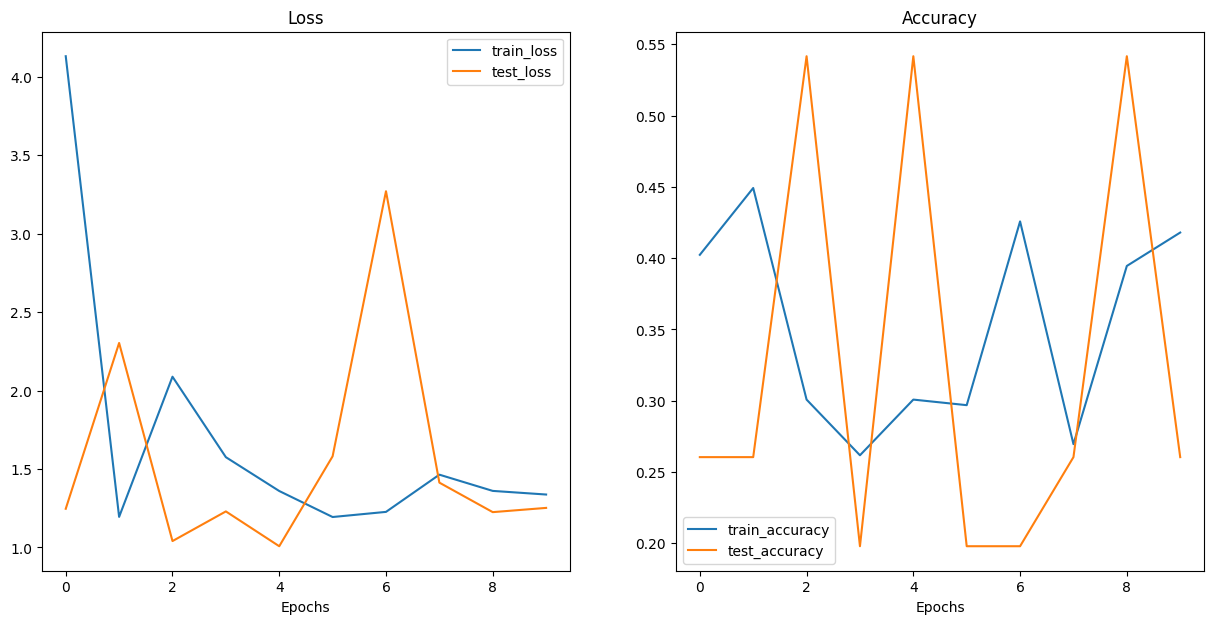

In [178]:
plot_loss_curves(results)

bad performance: underfitting and overfitting

data: only 225 images

prevent overfitting
* gradient clipping
* learning rate warmup and decay 

Use a pre-trained model such as torchvision.models.vit_b_16 is a good candidate for transfer learning, in case we only have a small dataset.